Dataset loaded successfully. Shape: (49, 33)
Missing values per column:
obj_regio1                             0
obj_heatingType                        9
obj_cId                                0
obj_newlyConst                         0
obj_pricetrend                         5
obj_yearConstructed                    9
obj_pricetrendbuy                      5
obj_firingTypes                        8
obj_ExclusiveExpose                    0
geo_bln                                0
obj_cellar                             0
obj_houseNumber                        0
obj_livingSpace                        0
geo_krs                                0
obj_zipCode                            0
obj_condition                          0
obj_street                             0
obj_streetPlain                        0
geo_plz                                0
obj_noRooms                            0
geo_land                               0
ga_cd_via                              0
obj_immotype              

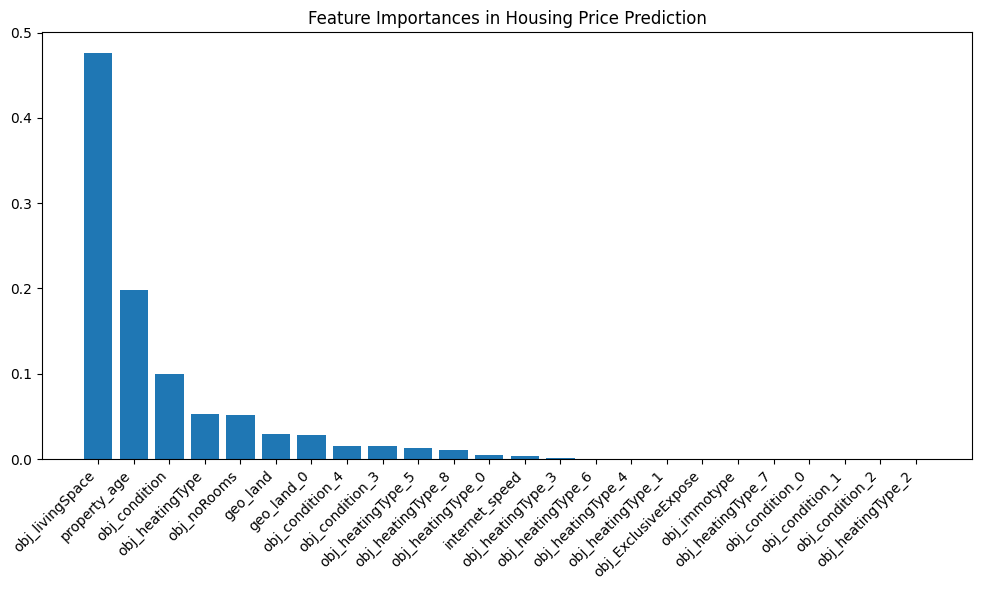


Total Execution Time: 23.15 seconds
Total Execution Time: 0.39 minutes


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

# Data processing and ML libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    mean_absolute_percentage_error
)

# Machine learning models
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

class GermanHousingDataProcessor:
    def __init__(self, data):
        """
        Initialize the data processor

        :param data: DataFrame or list of lists containing housing data
        """
        # Convert input to DataFrame if it's not already
        if not isinstance(data, pd.DataFrame):
            self.raw_data = pd.DataFrame(
                data,
                columns=[
                    'obj_regio1', 'obj_heatingType', 'obj_cId', 'obj_newlyConst',
                    'obj_pricetrend', 'obj_yearConstructed', 'obj_pricetrendbuy',
                    'obj_firingTypes', 'obj_ExclusiveExpose', 'geo_bln',
                    'obj_cellar', 'obj_houseNumber', 'obj_livingSpace', 'geo_krs',
                    'obj_zipCode', 'obj_condition', 'obj_street', 'obj_streetPlain',
                    'geo_plz', 'obj_noRooms', 'geo_land', 'ga_cd_via',
                    'obj_immotype', 'obj_telekomInternetProductAvailable',
                    'obj_barrierFree', 'obj_regio3', 'obj_objectnumber',
                    'obj_livingSpaceRange', 'obj_regio2', 'obj_telekomTvOffer',
                    'obj_telekomUploadSpeed', 'obj_telekomDownloadSpeed',
                    'obj_purchasePrice'
                ]
            )
        else:
            self.raw_data = data

        # Initialize processing attributes
        self.processed_data = None
        self.X = None
        self.y = None

    def comprehensive_preprocessing(self):
        """
        Comprehensive data preprocessing with advanced feature engineering
        """
        start_time = time.time()
        df = self.raw_data.copy()

        # 1. Handle missing values
        # Numeric columns
        numeric_cols = [
            'obj_livingSpace', 'obj_noRooms', 'obj_yearConstructed',
            'obj_pricetrend', 'obj_pricetrendbuy'
        ]
        for col in numeric_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col].fillna(df[col].median(), inplace=True)

        # 2. Property Age Feature
        current_year = 2020
        df['property_age'] = current_year - df['obj_yearConstructed'].fillna(current_year)

        # 3. Categorical Encoding
        categorical_cols = [
            'obj_regio1', 'obj_heatingType', 'obj_newlyConst',
            'obj_firingTypes', 'obj_condition', 'geo_land',
            'obj_immotype', 'obj_telekomInternetProductAvailable'
        ]

        # Label Encoding
        le = LabelEncoder()
        for col in categorical_cols:
            df[col] = df[col].fillna('Unknown')
            df[col] = le.fit_transform(df[col].astype(str))

        # 4. Binary Encoding
        binary_cols = ['obj_ExclusiveExpose', 'obj_barrierFree']
        for col in binary_cols:
            df[col] = df[col].map({'TRUE': 1, 'FALSE': 0, True: 1, False: 0})
            df[col].fillna(0, inplace=True)

        # 5. Internet Speed Feature
        df['internet_speed'] = df['obj_telekomDownloadSpeed'].str.extract('(\d+)').astype(float)
        df['internet_speed'].fillna(df['internet_speed'].median(), inplace=True)

        # 6. Feature Selection
        selected_features = [
            'obj_livingSpace', 'obj_noRooms', 'property_age',
            'obj_heatingType', 'geo_land', 'obj_condition',
            'obj_immotype', 'obj_ExclusiveExpose', 'internet_speed'
        ]

        # Prepare X and y
        self.X = df[selected_features]
        self.y = df['obj_purchasePrice']

        print(f"Preprocessing Time: {time.time() - start_time:.2f} seconds")
        print(f"Processed Features: {len(selected_features)}")

        return self.X, self.y

    def advanced_model_training(self, n_iter_search=50):
        """
        Advanced model training with randomized search
        """
        start_time = time.time()

        # Preprocessing pipeline
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(),
                 ['obj_livingSpace', 'obj_noRooms', 'property_age', 'internet_speed']),
                ('cat', OneHotEncoder(handle_unknown='ignore'),
                 ['obj_heatingType', 'geo_land', 'obj_condition',
                  'obj_immotype', 'obj_ExclusiveExpose'])
            ])

        # Random Forest with randomized search
        rf = RandomForestRegressor(random_state=42)

        # Reduced parameter search space
        param_distributions = {
            'regressor__n_estimators': [100, 200, 300],
            'regressor__max_depth': [10, 20, 30, None],
            'regressor__min_samples_split': [2, 5, 10],
            'regressor__min_samples_leaf': [1, 2, 4]
        }

        # Create pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', rf)
        ])

        # Randomized search with cross-validation
        random_search = RandomizedSearchCV(
            pipeline,
            param_distributions,
            n_iter=n_iter_search,
            cv=3,  # Reduced CV folds for speed
            scoring='neg_mean_squared_error',
            random_state=42,
            n_jobs=-1  # Use all available cores
        )

        # Fit the model
        random_search.fit(self.X, self.y)

        # Performance metrics
        best_model = random_search.best_estimator_
        best_params = random_search.best_params_

        # Cross-validation score
        cv_scores = cross_val_score(
            best_model,
            self.X,
            self.y,
            cv=3,
            scoring='neg_mean_squared_error'
        )

        print(f"\nModel Training Time: {time.time() - start_time:.2f} seconds")
        print("\nBest Model Parameters:")
        for param, value in best_params.items():
            print(f"{param}: {value}")

        print("\nCross-Validation Scores:")
        print(f"Mean MSE: {-cv_scores.mean():.4f}")
        print(f"Standard Deviation: {cv_scores.std():.4f}")

        return best_model, best_params

    def visualize_feature_importance(self, model):
      """
      Visualize feature importance
      """
      # Extract feature importances
      feature_names = list(self.X.columns)

      # Handle OneHotEncoding for categorical features
      if isinstance(model.named_steps['preprocessor'], ColumnTransformer):
          # Get the transformed feature names after one-hot encoding
          onehot_encoder = model.named_steps['preprocessor'].transformers_[1][1]
          categorical_cols = [
              'obj_heatingType', 'geo_land', 'obj_condition',
              'obj_immotype', 'obj_ExclusiveExpose'
          ]
          encoded_cols = onehot_encoder.get_feature_names_out(categorical_cols)

          # Append the one-hot encoded feature names
          feature_names = feature_names + list(encoded_cols)

      importances = model.named_steps['regressor'].feature_importances_

      # Sort feature importances in descending order
      indices = np.argsort(importances)[::-1]

      # Create plot
      plt.figure(figsize=(10, 6))
      plt.title("Feature Importances in Housing Price Prediction")
      plt.bar(range(len(importances)), importances[indices])
      plt.xticks(range(len(importances)),
                [feature_names[i] for i in indices],
                rotation=45,
                ha='right')
      plt.tight_layout()
      plt.show()


def main():
    # Replace sample_data with CSV loading
    file_path = '/content/apr.csv'  # Replace with your actual file path
    try:
        # Load data from CSV, treat empty strings as NaN
        df = pd.read_csv(file_path, na_values=["", "NA", "null"])
        print(f"Dataset loaded successfully. Shape: {df.shape}")
    except FileNotFoundError:
        print(f"Error: The file at {file_path} could not be found.")
        return

    # Check for missing values
    print(f"Missing values per column:\n{df.isnull().sum()}")

    # Total runtime tracking
    total_start_time = time.time()

    # Initialize processor with the loaded dataset
    processor = GermanHousingDataProcessor(df)

    # Preprocess data
    X, y = processor.comprehensive_preprocessing()

    # Train advanced model
    best_model, best_params = processor.advanced_model_training(
        n_iter_search=30  # Reduced iterations for faster runtime
    )

    # Visualize feature importance
    processor.visualize_feature_importance(best_model)

    # Total runtime
    total_runtime = time.time() - total_start_time
    print(f"\nTotal Execution Time: {total_runtime:.2f} seconds")
    print(f"Total Execution Time: {total_runtime/60:.2f} minutes")

if __name__ == "__main__":
    main()